In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(
    "dataset/jena_climate_2009_2016.zip", compression="zip", low_memory=False
)
df = df[["Date Time", "p (mbar)", "T (degC)"]]
df.info(verbose=True, memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date Time  420551 non-null  object 
 1   p (mbar)   420551 non-null  float64
 2   T (degC)   420551 non-null  float64
dtypes: float64(2), object(1)
memory usage: 9.6+ MB


In [3]:
df.head()

,Date Time,p (mbar),T (degC)
0,01.01.2009 00:10:00,996.52,-8.02
1,01.01.2009 00:20:00,996.57,-8.41
2,01.01.2009 00:30:00,996.53,-8.51
3,01.01.2009 00:40:00,996.51,-8.31
4,01.01.2009 00:50:00,996.51,-8.27


In [4]:
def set_time_index(
    df: pd.DataFrame, col_name: str, time_format: str = None
) -> pd.DataFrame:
    if col_name not in df.columns:
        raise Exception("Column {} is not in dataset: {}".format(col_name, df.columns))
    try:
        if time_format != None:
            df.index = pd.to_datetime(df[col_name], format=time_format)
        else:
            df.index = pd.to_datetime(df[col_name])
    except Exception as e:
        print("Unable to set {} as time index: {}".format(col_name, e))
    return df


df = set_time_index(df, "Date Time", time_format="%d.%m.%Y %H:%M:%S")
del df["Date Time"]

In [5]:
df.head()

,p (mbar),T (degC)
Date Time,,
2009-01-01 00:10:00,996.52,-8.02
2009-01-01 00:20:00,996.57,-8.41
2009-01-01 00:30:00,996.53,-8.51
2009-01-01 00:40:00,996.51,-8.31
2009-01-01 00:50:00,996.51,-8.27


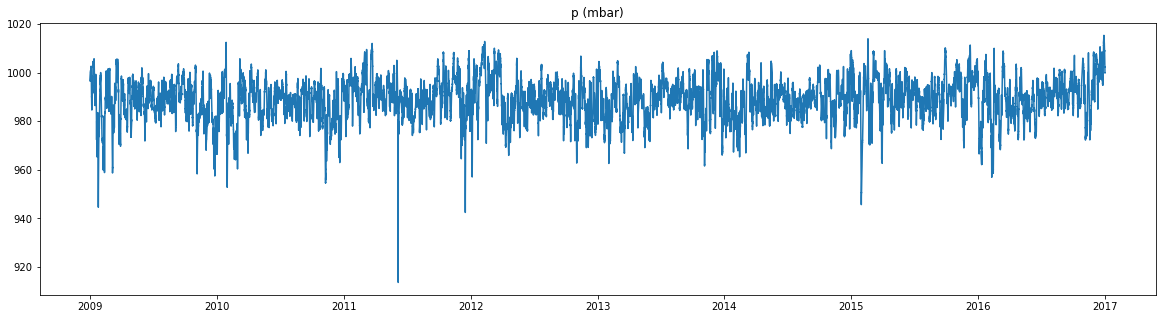

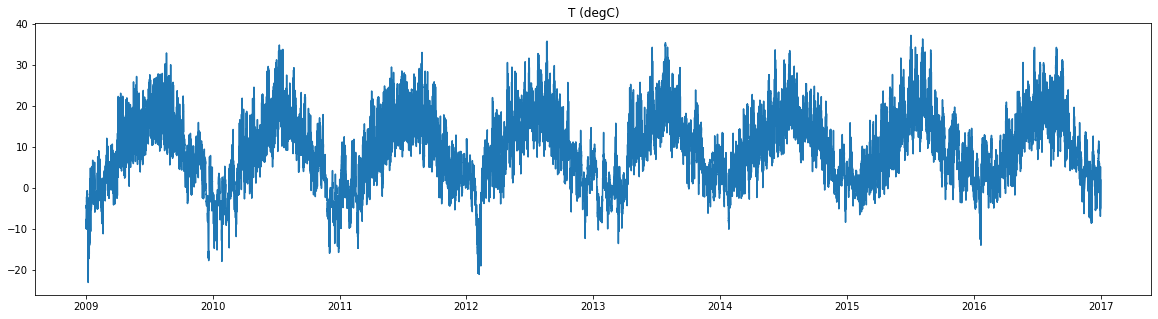

In [6]:
# df.plot(subplots=True)
import matplotlib.pyplot as plt

for i in df.columns:
    plt.figure(figsize=(20, 5))
    plt.title(i)
    plt.plot(df[i])

In [7]:
# interval-> Seconds to resample
def resample_df(df: pd.DataFrame, interval: int) -> pd.DataFrame:
    # Time interval is the number of seconds between each misuration
    time_interval = df.index.to_series().diff().dt.seconds.mode()[0]
    # These misuration break the rule, resample to `time_interval`
    df[df.index.to_series().diff().dt.seconds > time_interval]
    # Take only the integer part
    time_interval = str(int(time_interval))
    df = df.resample(time_interval + "S").mean().ffill().interpolate()
    assert (df.index.to_series().diff().dt.seconds > float(time_interval)).sum() == 0
    df = df.resample("{}".format(interval) + "S").mean().ffill().interpolate()
    assert (df.index.to_series().diff().dt.seconds > float(interval)).sum() == 0
    return df


import numpy as np


def normalize(values: np.ndarray):
    return (values - values.mean()) / np.std(values)

In [8]:
df.describe()

,p (mbar),T (degC)
count,420551.000000,420551.000000
mean,989.212776,9.450147
std,8.358481,8.423365
min,913.600000,-23.010000
25%,984.200000,3.360000
50%,989.580000,9.420000
75%,994.720000,15.470000
max,1015.350000,37.280000


In [9]:
# Resample to 1 day
df = resample_df(df, 86400)
# df["T (degC)"] = df["T (degC)"].astype("float16")
# df["p (mbar)"] = df["p (mbar)"].astype("float16")

# df["T (degC)"] = normalize(df["T (degC)"].values)
df.info(verbose=True, memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2923 entries, 2009-01-01 to 2017-01-01
Freq: 86400S
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   p (mbar)  2923 non-null   float64
 1   T (degC)  2923 non-null   float64
dtypes: float64(2)
memory usage: 68.5 KB


In [10]:
df.describe()

,p (mbar),T (degC)
count,2923.000000,2923.000000
mean,989.222404,9.438695
std,8.091493,7.836859
min,948.995972,-16.457292
25%,984.362674,3.811007
50%,989.530000,9.708333
75%,994.459410,15.419062
max,1013.957569,29.375347


# TENSORFLOW

In [11]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2080 Ti, compute capability 7.5


2021-11-11 19:01:39.990721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 19:01:39.994794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 19:01:39.995088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 19:01:39.995416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [12]:
df.head()

,p (mbar),T (degC)
Date Time,,
2009-01-01,999.145594,-6.810629
2009-01-02,999.600625,-3.728194
2009-01-03,998.548611,-5.271736
2009-01-04,988.510694,-1.375208
2009-01-05,990.405694,-4.867153


## Scale data

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = {}
columns = {}
for column in df.columns:
    sc = StandardScaler()
    scaler[column] = sc
    df_scaled = sc.fit_transform(df[column].to_numpy().reshape(-1, 1))
    columns[column] = df_scaled.ravel()
# df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

<AxesSubplot:>

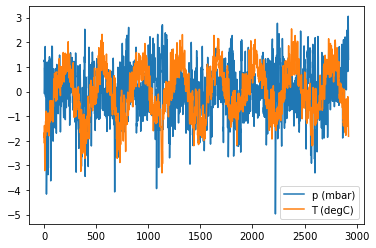

In [14]:
df_scaled = pd.DataFrame(columns)
df_scaled.plot()

In [15]:
numpy_x = df_scaled.values
# numpy_x = df.values
# numpy_x = numpy_x.reshape(numpy_x.shape[0], 1)
numpy_x.shape

(2923, 2)

In [16]:
import numpy as np


def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [17]:
# Use 366 days as history, predict 7 days
history_window = 366
n_prediction = 7
df_x, df_y = split_sequence(numpy_x, history_window, n_prediction)

In [18]:
df_y = df_y[:, :, 1]

In [19]:
df_x.shape, df_y.shape

((2551, 366, 2), (2551, 7))

In [20]:
# Reshaping into n_example, timestamps, features
df_x = df_x.reshape(df_x.shape[0], df_x.shape[1], 2)
df_x.shape

(2551, 366, 2)

In [21]:
# Reshaping in n_example, timestamps
df_y = df_y.reshape(df_y.shape[0], df_y.shape[1])
df_y.shape

(2551, 7)

In [22]:
# Reduce memory usage for Low End graphic cards
df_x = np.float16(df_x)
df_y = np.float16(df_y)

In [23]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.LSTM(
            512, input_shape=(df_x.shape[1], df_x.shape[2]), return_sequences=True,
        ),
        tf.keras.layers.LSTM(256, return_sequences=True),
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(df_y.shape[1]),
    ]
)
callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=10, restore_best_weights=True
)
opt = tf.keras.optimizers.Adam()
model.compile(
    optimizer=opt, loss="mse", metrics=["mae"],
)
model.summary()

2021-11-11 19:01:40.419897: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-11 19:01:40.436870: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x55cb9e9788d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-11-11 19:01:40.436890: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2021-11-11 19:01:40.493804: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 19:01:40.494144: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x55cb9f7ad1e0 initialized

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 366, 512)          1054720   
                                                                 
 lstm_1 (LSTM)               (None, 366, 256)          787456    
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 2,040,199
Trainable params: 2,040,199
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(df_x[:-1], df_y[:-1], epochs=1000, callbacks=[callback])

Epoch 1/1000


2021-11-11 19:01:44.167903: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


80/80 [==============================] - 7s 50ms/step - loss: 0.3427 - mae: 0.4596
Epoch 2/1000
80/80 [==============================] - 4s 48ms/step - loss: 0.2797 - mae: 0.4173
Epoch 3/1000
80/80 [==============================] - 4s 44ms/step - loss: 0.2583 - mae: 0.4016
Epoch 4/1000
80/80 [==============================] - 4s 47ms/step - loss: 0.2485 - mae: 0.3952
Epoch 5/1000
80/80 [==============================] - 4s 47ms/step - loss: 0.2345 - mae: 0.3809
Epoch 6/1000
80/80 [==============================] - 3s 38ms/step - loss: 0.2290 - mae: 0.3758
Epoch 7/1000
80/80 [==============================] - 4s 47ms/step - loss: 0.2339 - mae: 0.3795
Epoch 8/1000
80/80 [==============================] - 3s 36ms/step - loss: 0.2221 - mae: 0.3698
Epoch 9/1000
80/80 [==============================] - 3s 42ms/step - loss: 0.2173 - mae: 0.3644
Epoch 10/1000
80/80 [==============================] - 4s 45ms/step - loss: 0.2083 - mae: 0.3584
Epoch 11/1000
80/80 [==============================]

In [25]:
# Reshape input in order to have a single example with `history_window` timestamp
model_input = df_x[-1].reshape(1, history_window, 2)

In [26]:
model_prediction = model.predict(model_input).ravel()

In [27]:
d = {
    "real_values": scaler["T (degC)"]
    .inverse_transform(df_y[-1].reshape(-1, 1))
    .ravel(),
    "model_values": scaler["T (degC)"]
    .inverse_transform(model_prediction.reshape(-1, 1))
    .ravel(),
}

<AxesSubplot:>

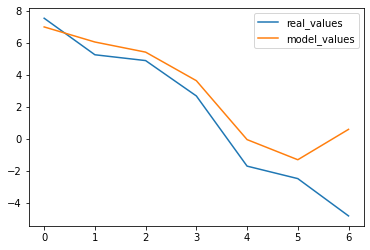

In [28]:
pd.DataFrame(d).plot()

In [29]:
model.save("my_model.h5")
model = tf.keras.models.load_model("my_model.h5")